In [15]:
%load_ext autoreload
%autoreload

import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
from joblib import dump, load
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

sys.path.append('../')
from utils import feature_selection, thomas_parser, PCA_reduction, perf, time_comparison
from toBoolean import convert

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Features relevance

In [2]:
gt = pd.read_csv('../../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

The following commands allow us to see how important each feature is in the decision process.

In [3]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04065378 0.01724961 0.
 0.         0.08984802 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.04027522 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.03249722 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0

Text(0, 0.5, 'Feature')

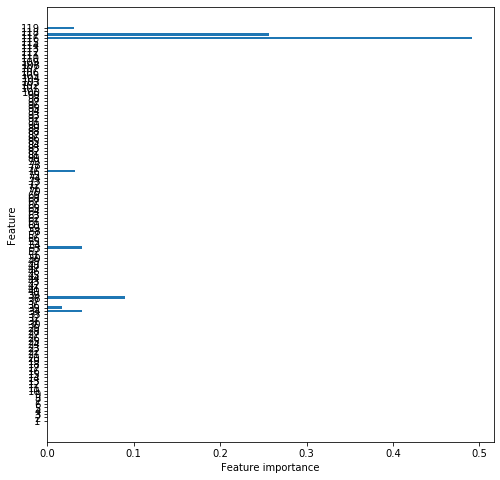

In [4]:
n_features = data.shape[1]
plt.rcParams["figure.figsize"] = (8,8)
plt.barh(range(n_features), tree.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), np.arange(1,120)) 
plt.xlabel("Feature importance")
plt.ylabel("Feature")

As we can see, out of 119 features only a very few are actually used by the learning algorithm. Let's apply some pruning on the features to see if it improves the accuracies (or even the speed of the process).

0.15
(1196, 119)
(1196, 7)
0.3
(2393, 119)
(2393, 7)
3
0.44999999999999996
(3589, 119)
(3589, 7)
2
0.6
(4786, 119)
(4786, 8)
2
0.75
(5982, 119)
(5982, 8)
2
0.9
(7179, 119)
(7179, 8)
2


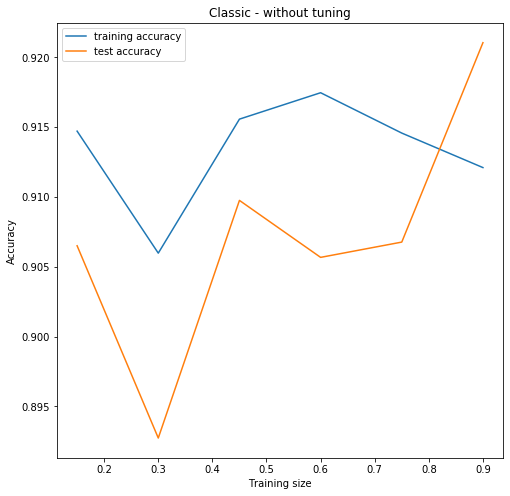

Training max value : 0.9174676138737986
Test max value : 0.9210526315789473


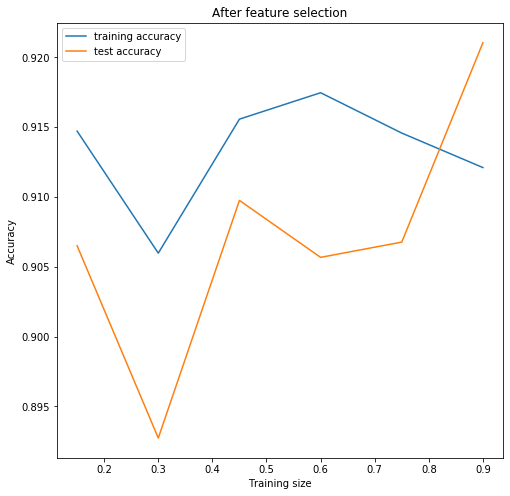

Training max value : 0.9174676138737986
Test max value : 0.9210526315789473


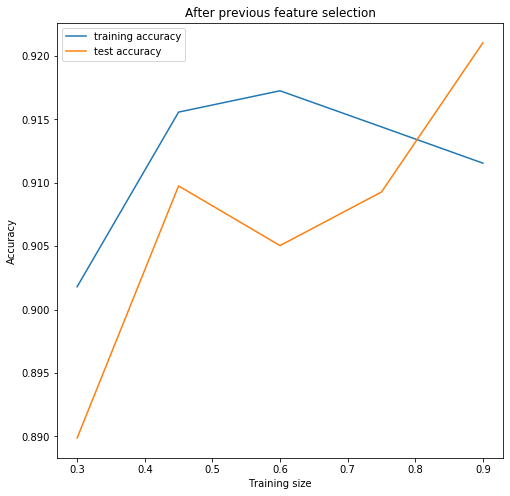

Training max value : 0.917258671124112
Test max value : 0.9210526315789473


In [16]:
feature_selection('../../dumps/2020.02.10-12.14.csv',0.15,"tree")

It's quite intuitive to see that there's no difference between the two first situations. Indeed, since not a lot of features are used anyway, doing a feature selection doesn't improve the accuracies. What is interesting to see is that on the last graph, the number of features used is even lower (between 2 and 3) but the results are nearly the same, which means that just a few features are doing most of the job.

Let's see if the performance can be improved when using a larger dataset which is nearly twice the size of the previous one (14703 entries).

In [17]:
feature_selection('../../dumps/2020.03.11-17.39.csv',0.15,"tree")

0.15
(2205, 119)
(2205, 6)
0.3
(4410, 119)
(4410, 6)
4
0.44999999999999996
(6616, 119)
(6616, 6)
3
0.6
(8821, 119)
(8821, 5)
0
0.75
(11027, 119)
(11027, 6)


ValueError: at least one array or dtype is required

We suffer the issue of not having enough features between the iterations to create an intersect with more than one value in common. Let's just see how it goes without the intersect.

0.15
(2205, 119)
(2205, 6)
0.3
(4410, 119)
(4410, 6)
0.44999999999999996
(6616, 119)
(6616, 6)
0.6
(8821, 119)
(8821, 5)
0.75
(11027, 119)
(11027, 6)
0.9
(13232, 119)
(13232, 6)


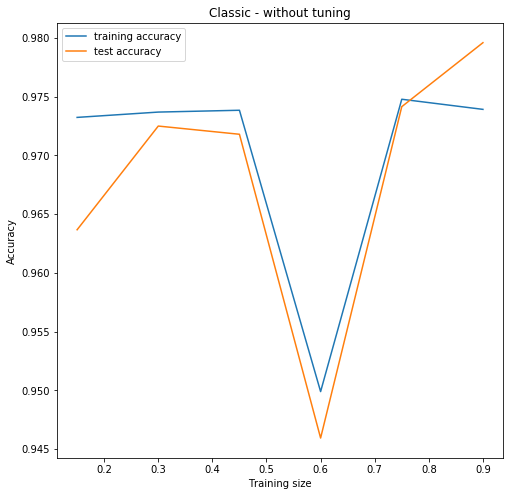

Training max value : 0.974789153894985
Test max value : 0.9796057104010877


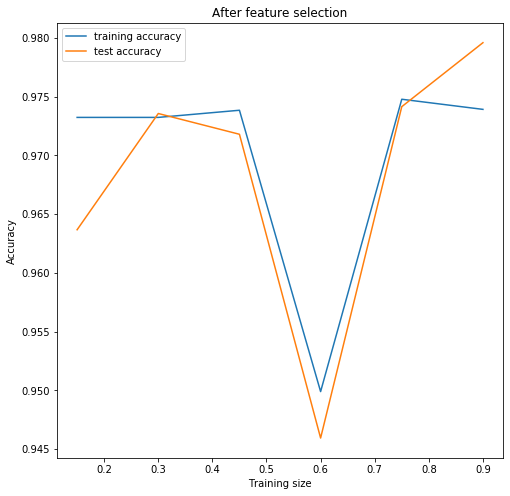

Training max value : 0.974789153894985
Test max value : 0.9796057104010877


In [14]:
feature_selection('../../dumps/2020.03.11-17.39.csv',0.15,"tree")

What shows up straight away is that by simply doubling the size of the dataset we went from a pure test accuracy of 0.92 up to 0.979 (with 90% training set), this is quite impressive ! We can also notice that there's no difference between the results we get with and without the feature extraction, which mean that the model could definittely be simplified to a few features. One last thing we can also observe is that we suffer from a huge drop when setting a value of 0.6 for the training set, which I cannot explain.